<a href="https://colab.research.google.com/github/MasDiptha12/Machine-Learning/blob/main/UTS/Regression_Models/Regression_Models_Predict_Continuous_Outcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Pengumpulan dan Pembersihan Data

Langkah pertama adalah mengimpor berdasarkan dataset yang telah diupload ke google colab dan melakukan pembersihan. Kita akan memuat data, menangani nilai yang kosongg, serta memastikan bahwa data sudah sesuai format yang bisa digunakan oleh model.

In [2]:
# Import library yang dibutuhkan
import pandas as pd

# Membaca data dari file yang diupload
df = pd.read_csv('/content/RegresiUTSTelkom.csv')

# Menampilkan nama kolom untuk memeriksa
print("Nama kolom dalam dataset:")
print(df.columns)

# Menampilkan 5 baris pertama dari data untuk pemeriksaan
df.head()

# Mengecek apakah ada nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())

# Menghapus baris dengan nilai yang hilang
df_cleaned = df.dropna()

# Mengecek apakah ada duplikat dalam data
df_cleaned = df_cleaned.drop_duplicates()

# Menampilkan statistik deskriptif dari data yang telah dibersihkan
print("\nStatistik Deskriptif Data:")
print(df_cleaned.describe())

Nama kolom dalam dataset:
Index(['2001', '49.94357', '21.47114', '73.0775', '8.74861', '-17.40628',
       '-13.09905', '-25.01202', '-12.23257', '7.83089', '-2.46783', '3.32136',
       '-2.31521', '10.20556', '611.10913', '951.0896', '698.11428',
       '408.98485', '383.70912', '326.51512', '238.11327', '251.42414',
       '187.17351', '100.42652', '179.19498', '-8.41558', '-317.87038',
       '95.86266', '48.10259', '-95.66303', '-18.06215', '1.96984', '34.42438',
       '11.7267', '1.3679', '7.79444', '-0.36994', '-133.67852', '-83.26165',
       '-37.29765', '73.04667', '-37.36684', '-3.13853', '-24.21531',
       '-13.23066', '15.93809', '-18.60478', '82.15479', '240.5798',
       '-10.29407', '31.58431', '-25.38187', '-3.90772', '13.29258', '41.5506',
       '-7.26272', '-21.00863', '105.50848', '64.29856', '26.08481',
       '-44.5911', '-8.30657', '7.93706', '-10.7366', '-95.44766', '-82.03307',
       '-35.59194', '4.69525', '70.95626', '28.09139', '6.02015', '-37.13767',
  

# 2. Feature Selection

Di tahap ini, kita memilih fitur yang paling berpengaruh terhadap target agar model bekerja lebih efisien. Kita buang fitur yang isinya sama, yang saling duplikat, atau terlalu mirip satu sama lain. Lalu kita cek seberapa besar pengaruh tiap fitur terhadap target, agar hanya fitur penting yang digunakan di model selanjutnya.

In [3]:
# Import library yang dibutuhkan untuk seleksi fitur
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import pandas as pd

# Menggunakan kolom selain target untuk fitur X
X = df_cleaned.drop(columns='2001')  # '2001' sebagai kolom target
y = df_cleaned['2001']  # '2001' sebagai kolom target

# Menghapus fitur dengan variansi rendah
selector = VarianceThreshold(threshold=0.01)  # Variansi rendah akan dihapus
X_cleaned = selector.fit_transform(X)

# Menghitung korelasi antar fitur
corr_matrix = X.corr()

# Menghapus fitur yang memiliki korelasi lebih dari threshold (misalnya 0.9)
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column].abs() > 0.9)]
X_cleaned = X.drop(columns=to_drop)

# Pilih fitur terbaik dengan menggunakan Mutual Information
mutual_info = mutual_info_regression(X_cleaned, y)
mutual_info = pd.Series(mutual_info, index=X_cleaned.columns)
mutual_info_sorted = mutual_info.sort_values(ascending=False)

# Pilih 10 fitur terbaik berdasarkan Mutual Information
X_selected = X_cleaned[mutual_info_sorted.head(10).index]

# 3. Feature Engineering

Tahap ini bertujuan mengubah data mentah menjadi format yang lebih mudah dipahami oleh model. Misalnya, kita bisa mengubah data kategori menjadi angka dengan label encoding atau one-hot encoding, dan melakukan transformasi data agar distribusinya lebih stabil. Ini membantu model memahami pola dalam data dengan lebih baik.

In [4]:
# Import library untuk preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Misalkan jika ada fitur kategorikal, lakukan encoding
# (Jika tidak ada fitur kategorikal, bisa dilewati)
if 'categorical_column' in df_cleaned.columns:
    le = LabelEncoder()
    df_cleaned['categorical_column'] = le.fit_transform(df_cleaned['categorical_column'])

# Lakukan normalisasi pada fitur numerik terpilih
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# Membagi data menjadi data latih dan data uji
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# 4. Model Training
Di sini, kita melatih berbagai model regresi untuk membandingkan performanya. Model yang digunakan seperti Linear Regression, Decision Tree, KNN, hingga model ensemble seperti Bagging, AdaBoost, dan Gradient Boosting. Setiap model akan belajar dari data fitur untuk memprediksi nilai target seakurat mungkin.

In [6]:
# Import model regresi
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline  # <--- Tambahkan ini
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# List model yang akan digunakan
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())]),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Bagging Regressor': BaggingRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

# Melatih dan mengevaluasi model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluasi menggunakan metrik
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Simpan hasil evaluasi
    results[name] = {'RMSE': rmse, 'MSE': mse, 'R^2': r2}

# Tampilkan hasil evaluasi
results_df = pd.DataFrame(results).T
print("\nEvaluasi Model:")
print(results_df)


Evaluasi Model:
                                    RMSE         MSE       R^2
Linear Regression               9.619051   92.526147  0.129706
Polynomial Regression           9.435770   89.033748  0.162555
Decision Tree Regressor        13.248014  175.509884 -0.650832
K-Nearest Neighbors Regressor   9.500805   90.265304  0.150972
Bagging Regressor               9.584138   91.855699  0.136012
AdaBoost Regressor             11.727383  137.531522 -0.293611
Gradient Boosting Regressor     9.238554   85.350881  0.197196
SVR                             9.518375   90.599459  0.147828


# 5. Evaluasi Model (MSE, RMSE, R²) dan Visualisasi Prediksi vs Actual
Penjelasan:
Pada langkah ini, kita akan mengevaluasi model yang sudah dilatih menggunakan metrik MSE (Mean Squared Error), RMSE (Root Mean Squared Error), dan R² (Coefficient of Determination). Setelah itu, kita juga akan memvisualisasikan perbandingan antara nilai prediksi dan nilai aktual dari model untuk memahami bagaimana kinerja model.


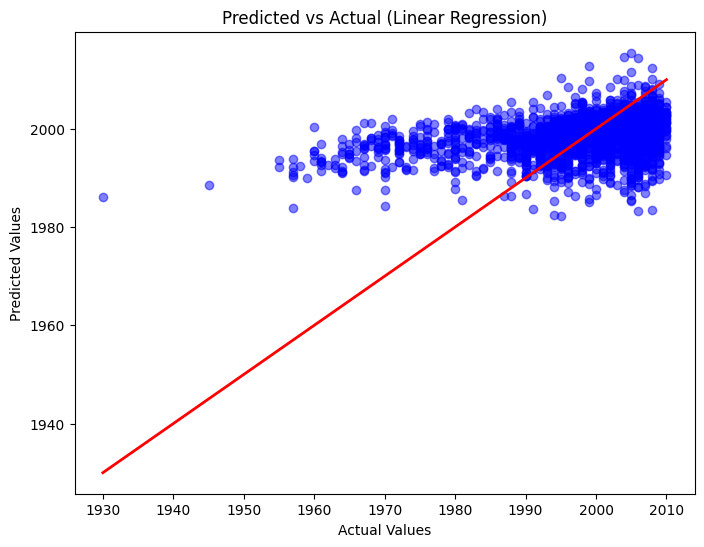

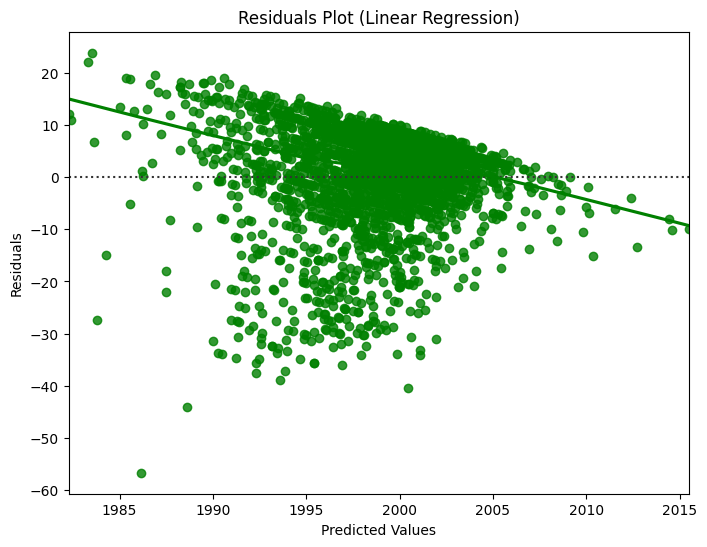

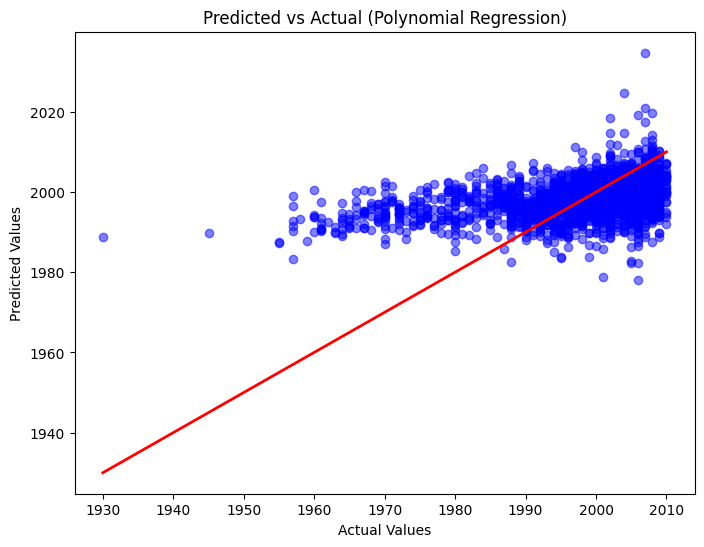

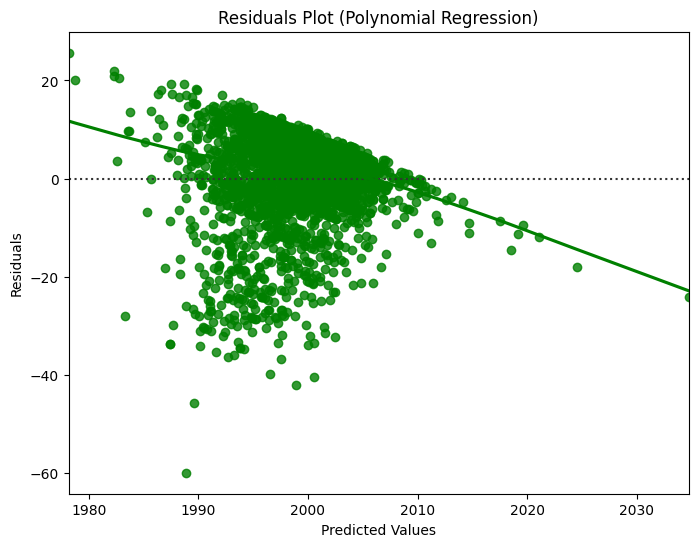

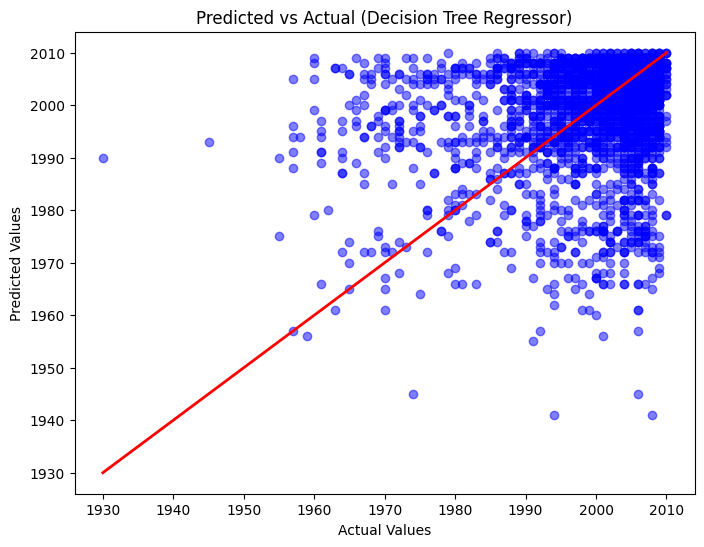

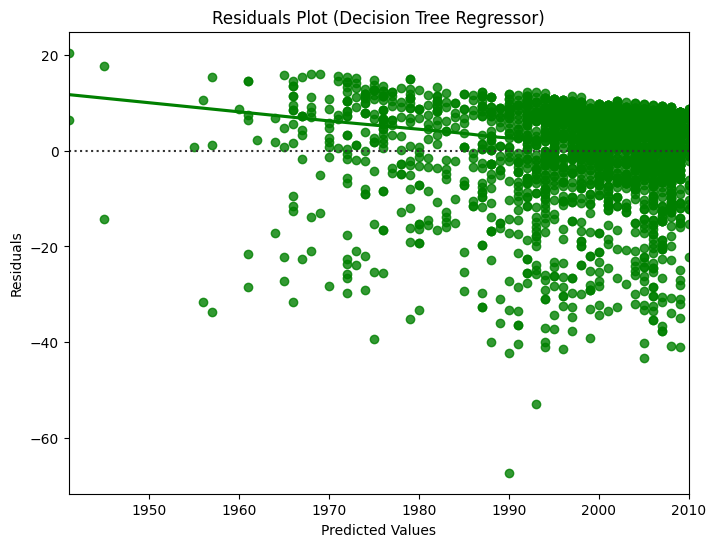

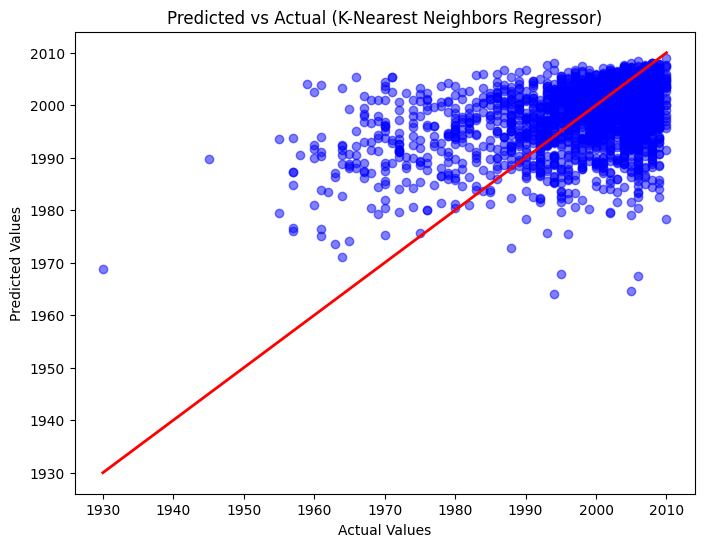

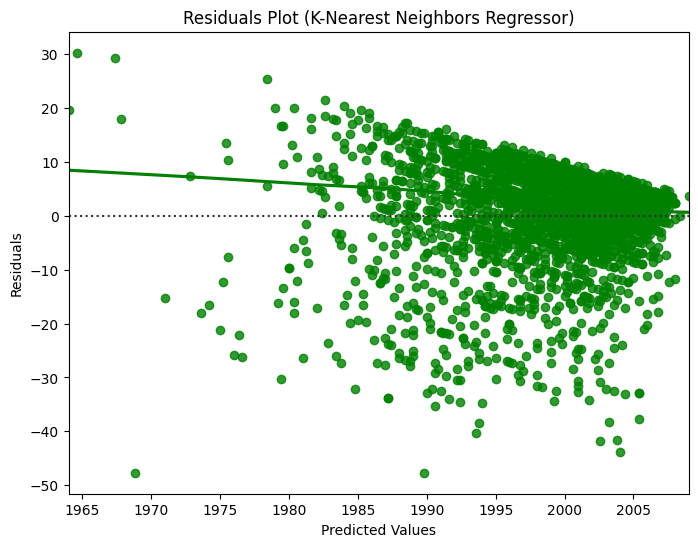

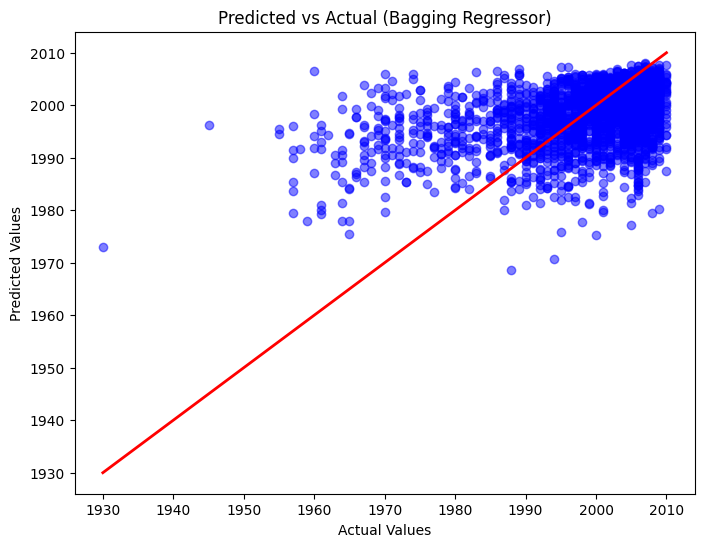

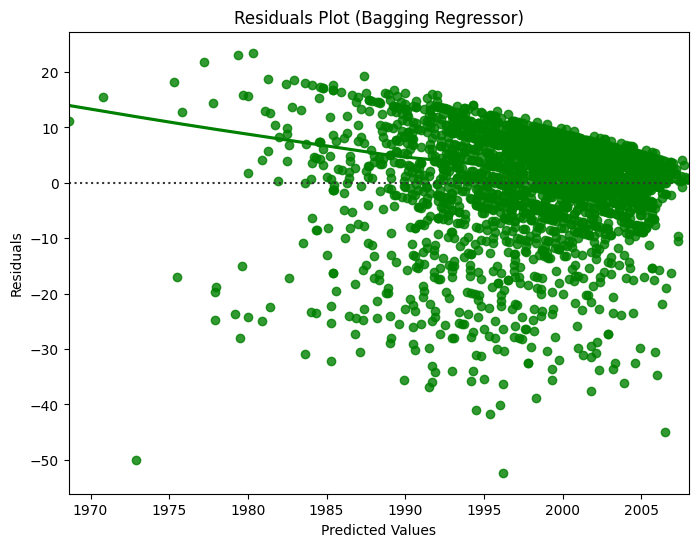

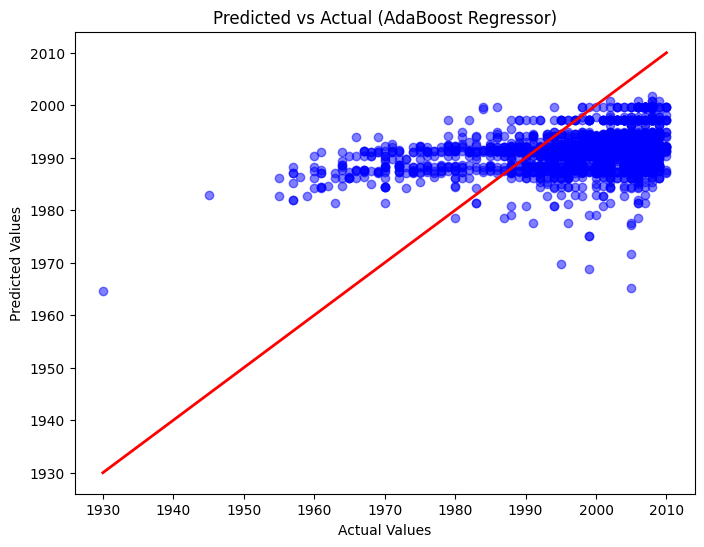

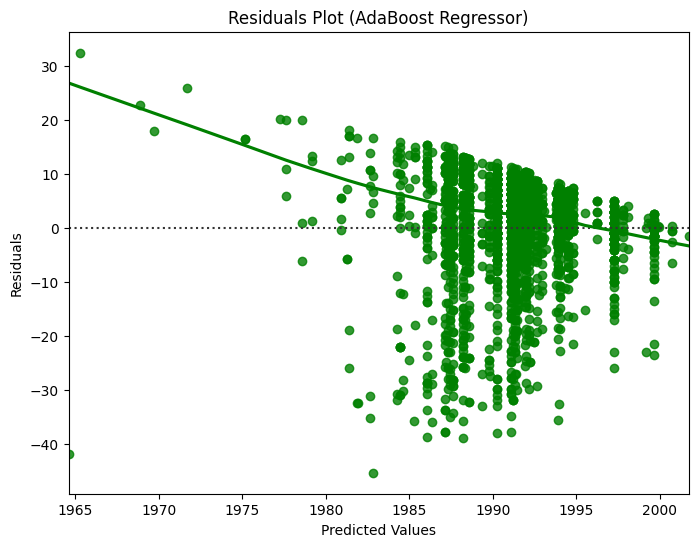

In [11]:
# Import library yang diperlukan
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fungsi untuk visualisasi Predicted vs Actual
def plot_predicted_vs_actual(model_name, y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.title(f'Predicted vs Actual ({model_name})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

# Fungsi untuk visualisasi Residuals Plot
def plot_residuals(model_name, y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, color='green')
    plt.title(f'Residuals Plot ({model_name})')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

# Evaluasi dan visualisasi untuk setiap model
metrics_dict = {}

for name, model in trained_models.items():
    # Prediksi dengan model
    y_pred = model.predict(X_test)

    # Menghitung metrik evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Simpan metrik untuk visualisasi
    metrics_dict[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

    # Visualisasi Predicted vs Actual
    plot_predicted_vs_actual(name, y_test, y_pred)

    # Visualisasi Residuals Plot
    plot_residuals(name, y_test, y_pred)

# 6. Visualisasi Metrik Evaluasi (MSE, RMSE, R² per Model)

Langkah ini bertujuan untuk memvisualisasikan metrik evaluasi untuk setiap model yang telah diuji. Metrik yang digunakan adalah MSE, RMSE, dan R². Visualisasi ini akan memberikan gambaran perbandingan antar model berdasarkan kinerjanya.

<Figure size 1000x600 with 0 Axes>

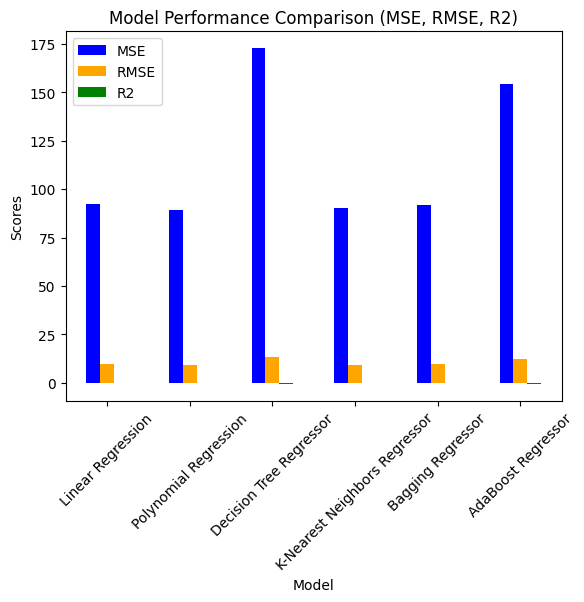

In [12]:
# Fungsi untuk plot metrik evaluasi per model
def plot_model_metrics(metrics_dict):
    # Mengubah metrik menjadi DataFrame untuk memudahkan visualisasi
    metrics_df = pd.DataFrame(metrics_dict).T

    # Plotting MSE, RMSE, dan R²
    plt.figure(figsize=(10, 6))
    metrics_df[['MSE', 'RMSE', 'R2']].plot(kind='bar', color=['blue', 'orange', 'green'])
    plt.title('Model Performance Comparison (MSE, RMSE, R2)')
    plt.xlabel('Model')
    plt.ylabel('Scores')
    plt.xticks(rotation=45)
    plt.show()

# Panggil fungsi untuk visualisasi metrik
plot_model_metrics(metrics_dict)

# Penjelasan Model dan Perhitungan Matematis

## 1. Linear Regression (Regresi Linear)

**Matematika Dasar:**  
Model regresi linear berasumsi bahwa hubungan antara variabel independen (fitur) dan variabel dependen (target) dapat dijelaskan dengan persamaan linear berikut:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
$$

Di mana:
- \( y \) adalah nilai prediksi (target),
- \( x_1, x_2, \dots, x_n \) adalah fitur (variabel independen),
- \( \beta_0 \) adalah intercept (nilai konstanta),
- \( \beta_1, \beta_2, \dots, \beta_n \) adalah koefisien yang menunjukkan seberapa besar pengaruh setiap fitur terhadap target,
- \( \epsilon \) adalah error atau residu, yang mewakili perbedaan antara nilai prediksi dan nilai aktual.

**Tujuan:**  
Model ini bertujuan untuk mencari nilai koefisien $$ ((\beta_1, \beta_2, \dots, \beta_n) $$ yang meminimalkan kesalahan prediksi (error) dengan menggunakan teknik seperti **Ordinary Least Squares (OLS)**.

---

## 2. Polynomial Regression (Regresi Polinomial)

**Matematika Dasar:**  
Polynomial Regression adalah ekstensi dari regresi linear yang memungkinkan hubungan non-linear antara fitur dan target. Modelnya dapat dituliskan sebagai:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_n x^n + \epsilon
$$

Di mana:
- \( x^n \) adalah fitur yang dipangkatkan, yang memungkinkan model untuk menangkap hubungan non-linear.

**Tujuan:**  
Menambahkan derajat polinomial untuk fitur memungkinkan model menangkap pola non-linear dalam data, sehingga model ini dapat digunakan jika data tidak memenuhi asumsi linearitas.

---

## 3. Decision Tree Regressor (Pohon Keputusan untuk Regresi)

**Matematika Dasar:**  
Model pohon keputusan membagi dataset menjadi beberapa subset berdasarkan nilai fitur. Setiap cabang mewakili keputusan atau kondisi untuk memisahkan data, dan setiap daun memberikan nilai prediksi untuk target. Secara matematis, proses pembentukan pohon keputusan tidak menggunakan persamaan kontinu seperti dalam regresi linear, tetapi menggunakan aturan pemisahan berdasarkan nilai fitur.

**Prinsip Pemisahan:**  
Pohon keputusan berusaha untuk meminimalkan **squared error** (kesalahan kuadrat) pada setiap cabang, yang dapat dihitung dengan rumus:

$$
\text{Error} = \sum_{i=1}^{N} (y_i - \hat{y})^2
$$

Di mana:
- \( y_i \) adalah nilai aktual,
- \( \hat{y} \) adalah nilai prediksi yang dihitung rata-rata di setiap daun.

---

## 4. K-Nearest Neighbors (KNN) Regressor

**Matematika Dasar:**  
KNN bekerja dengan menghitung jarak antara titik data yang ingin diprediksi dan titik data lainnya. Jarak dihitung menggunakan **Euclidean distance**:

$$
d(x_i, x_j) = \sqrt{\sum_{k=1}^{n} (x_{i,k} - x_{j,k})^2}
$$

Setelah jarak dihitung, model akan memilih \(k\) titik data terdekat dan melakukan prediksi target sebagai rata-rata dari target titik terdekat:

$$
\hat{y} = \frac{1}{k} \sum_{i=1}^{k} y_i
$$

Di mana:
- \( x_i \) dan \( x_j \) adalah titik data yang berbeda, dengan dimensi \(n\),
- \( y_i \) adalah target dari titik data terdekat.

---

## 5. Bagging Regressor (Bootstrap Aggregating)

**Matematika Dasar:**  
Bagging adalah teknik ensemble yang menggabungkan hasil dari beberapa model yang dilatih pada subset data yang berbeda. Setiap model dilatih menggunakan subset yang dipilih secara acak (dengan penggantian) dari dataset, dan prediksi akhir dihitung sebagai rata-rata dari hasil prediksi semua model.

Secara matematis, prediksi akhir \( \hat{y}_{\text{bagging}} \) adalah rata-rata dari prediksi model-model dasar:

$$
\hat{y}_{\text{bagging}} = \frac{1}{M} \sum_{m=1}^{M} \hat{y}_m
$$

Di mana:
- \( \hat{y}_m \) adalah prediksi dari model ke-\( m \),
- \( M \) adalah jumlah model dalam ensemble.

---

## 6. AdaBoost Regressor (Adaptive Boosting)

**Matematika Dasar:**  
AdaBoost mengadaptasi bobot data berdasarkan kesalahan prediksi dari model sebelumnya. Model pertama dilatih pada dataset asli, dan model berikutnya dilatih dengan memberi bobot lebih pada data yang salah diprediksi oleh model sebelumnya. Proses ini diulang untuk sejumlah iterasi.

Prediksi akhir dihitung sebagai kombinasi berbobot dari prediksi setiap model. Bobot setiap model dihitung berdasarkan kesalahannya:

$$
\hat{y}_{\text{ada}} = \sum_{m=1}^{M} \alpha_m \hat{y}_m
$$

Di mana:
- \( \hat{y}_m \) adalah prediksi model ke-\( m \),
- \( \alpha_m \) adalah bobot model ke-\( m \), yang dihitung berdasarkan kesalahan model,
- \( M \) adalah jumlah model.

---

## 7. Gradient Boosting Regressor

**Matematika Dasar:**  
Gradient Boosting berfungsi dengan cara membangun model secara bertahap, di mana model baru berusaha mengoreksi kesalahan model sebelumnya. Proses ini menggunakan **gradient descent** untuk mengoptimalkan fungsi kerugian (loss function). Misalnya, jika kita menggunakan Mean Squared Error (MSE) sebagai fungsi kerugian, maka prediksi dari model ke-\( m \) dihitung sebagai:

$$
\hat{y}_{m} = \hat{y}_{m-1} + \eta \cdot \nabla L(\hat{y}_{m-1})
$$

Di mana:
- \( \hat{y}_{m-1} \) adalah prediksi model sebelumnya,
- \( \eta \) adalah learning rate,
- \( \nabla L \) adalah gradien dari fungsi kerugian.

---

## 8. Support Vector Regression (SVR)

**Matematika Dasar:**  
SVR adalah aplikasi dari Support Vector Machines (SVM) untuk regresi. Tujuan dari SVR adalah menemukan sebuah hyperplane yang meminimalkan kesalahan dalam prediksi, namun membatasi kesalahan lebih besar dari nilai tertentu (epsilon). Fungsi objektif untuk SVR adalah meminimalkan:

$$
\min_{\mathbf{w}, b, \epsilon} \frac{1}{2} \| \mathbf{w} \|^2 + C \sum_{i=1}^{N} \epsilon_i
$$

Di mana:
- \( \mathbf{w} \) adalah vektor bobot untuk hyperplane,
- \( b \) adalah bias dari hyperplane,
- \( \epsilon_i \) adalah jarak error untuk setiap titik data,
- \( C \) adalah parameter regularisasi yang mengontrol trade-off antara margin dan kesalahan.

SVR memungkinkan untuk penggunaan kernel non-linear untuk menangkap hubungan non-linear antara fitur dan target.